In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import pandas as pd
import datetime

In [2]:
iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2.nc'
stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'

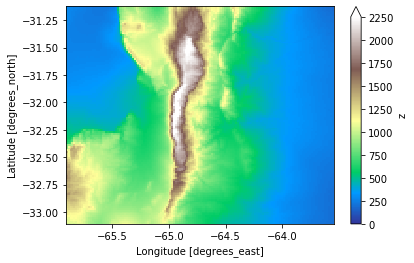

In [3]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [16]:
ds = xr.open_dataset(stats_file)
ds

<xarray.Dataset>
Dimensions:                  (times: 60, tracks: 6865)
Coordinates:
  * tracks                   (tracks) int32 0 1 2 3 4 ... 6861 6862 6863 6864
  * times                    (times) int32 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
Data variables:
    lifetime                 (tracks) float64 ...
    basetime                 (tracks, times) datetime64[ns] ...
    core_meanlat             (tracks, times) float32 ...
    core_meanlon             (tracks, times) float32 ...
    core_mean_y              (tracks, times) float32 ...
    core_mean_x              (tracks, times) float32 ...
    cell_meanlat             (tracks, times) float32 ...
    cell_meanlon             (tracks, times) float32 ...
    cell_mean_y              (tracks, times) float32 ...
    cell_mean_x              (tracks, times) float32 ...
    cell_minlat              (tracks, times) float32 ...
    cell_minlon              (tracks, times) float32 ...
    cell_maxlat              (tracks, times) float32 ...
    cell_maxlon              (tracks, times) float32 ...
    cell_min_y               (tracks, times) float32 ...
    cell_min_x               (tracks, times) float32 ...
    cell_max_y               (tracks, times) float32 ...
    cell_max_x               (tracks, times) float32 ...
    dilatecell_meanlat       (tracks, times) float32 ...
    dilatecell_meanlon       (tracks, times) float32 ...
    dilatecell_mean_y        (tracks, times) float32 ...
    dilatecell_mean_x        (tracks, times) float32 ...
    core_radius              (tracks, times) float32 ...
    cell_radius              (tracks, times) float32 ...
    core_area                (tracks, times) float32 ...
    cell_area                (tracks, times) float32 ...
    maxdbz                   (tracks, times) float32 ...
    maxETH_10dbz             (tracks, times) float32 ...
    maxETH_20dbz             (tracks, times) float32 ...
    maxETH_30dbz             (tracks, times) float32 ...
    maxETH_40dbz             (tracks, times) float32 ...
    maxETH_50dbz             (tracks, times) float32 ...
    cloudnumber              (tracks, times) float64 ...
    status                   (tracks, times) float64 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_tracknumber  (tracks) float64 ...
    start_split_timeindex    (tracks) float64 ...
    start_split_cloudnumber  (tracks) float64 ...
    end_merge_tracknumber    (tracks) float64 ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
    merge_tracknumbers       (tracks, times) float64 ...
    split_tracknumbers       (tracks, times) float64 ...
    trackinterruptions       (tracks) float64 ...
    maxrange_flag            (tracks, times) float64 ...
Attributes:
    title:                 File containing statistics for each track
    Institution:           Pacific Northwest National Laboratoy
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Wed Jul  1 05:25:28 2020
    source:                CSAPR2
    description:           COR
    startdate:             20181015.0000
    enddate:               20190303.0000
    track_version:         v1.0
    tracknumbers_version:  v1.0
    timegap_hour:          0.5
    time_resolution_hour:  0.25
    pixel_radius_km:       0.5

In [17]:
time_res = ds.attrs['time_resolution_hour']
tracks = ds.tracks
times = ds.times

xtimes = times * time_res
xtimes

# lifetime = stats['lifetime'] * time_res
# start_time = stats['start_basetime']
# end_time = stats['end_basetime']
# end_merge_tracknumber = stats['end_merge_tracknumber']
# start_split_tracknumber = stats['start_split_tracknumber']
# cell_lon = stats['cell_meanlon']
# cell_lat = stats['cell_meanlat']
# cell_area = stats['cell_area']
# maxrange_flag = stats['maxrange_flag']
# status = stats['status']

# eth10 = stats['maxETH_10dbz']
# eth20 = stats['maxETH_20dbz']
# eth30 = stats['maxETH_30dbz']
# eth40 = stats['maxETH_40dbz']
# eth50 = stats['maxETH_50dbz']

In [34]:
start_datetime = '2019-01-25T17'
end_datetime = '2019-01-26T00'

# Find track indices that initiate within the input datetime window
idx = np.where((ds.start_basetime.values >= np.datetime64(start_datetime)) & (ds.start_basetime.values <= np.datetime64(end_datetime)))[0]

start_time = ds.start_basetime.isel(tracks=idx)
duration = ds.lifetime.isel(tracks=idx)
lifetime = duration * time_res
cell_lon = ds.cell_meanlon.isel(tracks=idx)
cell_lat = ds.cell_meanlat.isel(tracks=idx)
cell_area = ds.cell_area.isel(tracks=idx)
eth30 = ds.maxETH_30dbz.isel(tracks=idx)
start_split_tracknumber = ds.start_split_tracknumber.isel(tracks=idx)
end_merge_tracknumber = ds.end_merge_tracknumber.isel(tracks=idx)
status = ds.status.isel(tracks=idx)

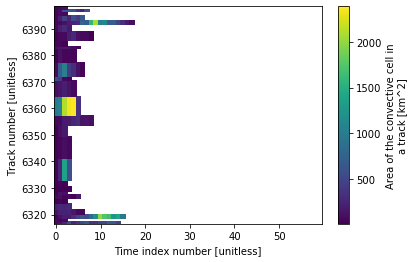

In [25]:
cell_area.where(lifetime > 0.5, drop=True).plot()

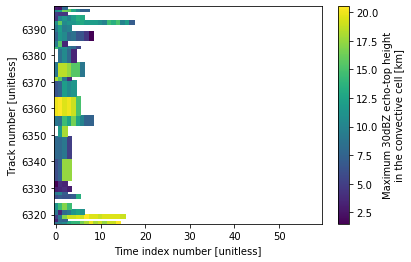

In [26]:
eth30.where(lifetime > 0.5, drop=True).plot()

In [41]:
lifetime_long = lifetime.where(lifetime > 0.5, drop=True)
cell_area_long = cell_area.where(lifetime > 0.5, drop=True)
eth30_long = eth30.where(lifetime > 0.5, drop=True)
start_split_tracknumber_long = start_split_tracknumber.where(lifetime > 0.5, drop=True)
end_merge_tracknumber_long = end_merge_tracknumber.where(lifetime > 0.5, drop=True)

ntracks_long = lifetime_long.size

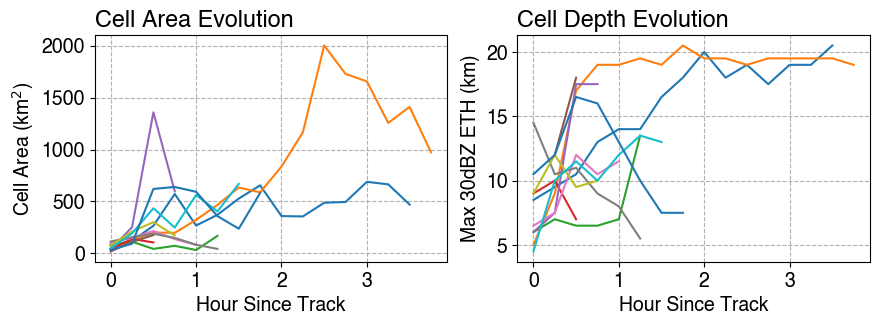

In [53]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)

ax1 = axes[0]
for itrack in range(0, ntracks_long):
    if (~np.isnan(end_merge_tracknumber_long.values[itrack])):
        ax1.plot(xtimes, cell_area_long.values[itrack,:])
ax1.set_ylabel('Cell Area (km$^{2}$)')
ax1.set_xlabel('Hour Since Track')
ax1.set_title('Cell Area Evolution', loc='left')
ax1.grid(ls='--')

ax2 = axes[1]
for itrack in range(0, ntracks_long):
    if (~np.isnan(end_merge_tracknumber_long.values[itrack])):
        ax2.plot(xtimes, eth30_long.values[itrack,:])
ax2.set_ylabel('Max 30dBZ ETH (km)')
ax2.set_xlabel('Hour Since Track')
ax2.set_title('Cell Depth Evolution', loc='left')
ax2.grid(ls='--')

fig.savefig(f'{figdir}case_cellarea_ETH30dbz_track_evolution_{start_datetime}.png', dpi=200, bbox_inches='tight')

In [50]:
f'case_cellarea_ETH30dbz_track_evolution_{start_datetime}.png'

'case_cellarea_ETH30dbz_track_evolution_2019-01-25T17.png'